In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
sldr = widgets.IntSlider(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
print(sldr.value)

7


In [2]:
from matplotlib import pyplot as plt
import copy
import numpy as np
import pandas as pd
import scipy
from scipy.signal import savgol_filter
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import sys
import time
from __future__ import absolute_import, division
import numbers
from collections import defaultdict

cols = ['chest_acc_x','chest_acc_y','chest_acc_z',
        'chest_mag_x','chest_mag_y','chest_mag_z',
        'chest_gyro_x','chest_gyro_y','chest_gyro_z',
        'arm_acc_x','arm_acc_y','arm_acc_z',
        'arm_mag_x','arm_mag_y','arm_mag_z',
        'arm_gyro_x','arm_gyro_y','arm_gyro_z',
        'leg_acc_x','leg_acc_y','leg_acc_z',
        'leg_mag_x','leg_mag_y','leg_mag_z',
        'leg_gyro_x','leg_gyro_y','leg_gyro_z',
        'chest_quar_w','chest_quar_x','chest_quar_y','chest_quar_z',
        'arm_quar_w','arm_quar_x','arm_quar_y','arm_quar_z',
        'leg_quar_w','leg_quar_x','leg_quar_y','leg_quar_z',
        'class']

ref_cols = ['leg_acc_x','leg_acc_y','leg_acc_z',
            'leg_mag_x','leg_mag_y','leg_mag_z',
            'leg_gyro_x','leg_gyro_y','leg_gyro_z',
            'leg_quar_w','leg_quar_x','leg_quar_y','leg_quar_z']
pth2data = "D:\Dropbox\Ju\EDI\Convergence\CapturedData\EDI-Data\Aleksandrs-1528981740.csv" 
#"D:\Dropbox\Ju\EDI\Convergence\CapturedData\EDI-Activity-Database-16-08-2019-Clean\Juris_O1-1564042571.csv"

#"D:\Dropbox\Ju\EDI\Convergence\CapturedData\EDI-Data\Andis-1528983909.csv"  
# #


pth2data2 = "D:\Dropbox\Ju\EDI\Convergence\CapturedData\Squats\pietupieni_nepareizi_4_mazs_squat.csv"
pth2ref2 = "D:\Dropbox\Ju\EDI\Convergence\CapturedData\Squats\pietupieni_pareizi_1.csv"

In [3]:
class curve:
    def __init__(self,x,y):
        if(len(x)!=len(y)):
            raise ValueError('x and y must be the same length')
        self.x = np.array(x)
        self.y = np.array(y)
        self.i = 0
        self._data_len = len(self.x)
    def __len__(self):
        return self._data_len
    def __plot__(self):
        return self.x,self.y
    def __next__(self):
        pass
    def __iter__(self):
        return curve_iterator(self)
    def copy(self):
        return curve(self.x.copy(),self.y.copy())
class curve_iterator:
    def __init__(self,crv):
        self._curve=crv
        self._index = 0
    def __next__(self):
        if self._index < (len(self._curve.x)):
            result = curve([self._curve.x[self._index]],[self._curve.y[self._index]])
            self._index+=1
            return result
        raise StopIteration

In [4]:
cols = ['chest_acc_x','chest_acc_y','chest_acc_z',
        'chest_mag_x','chest_mag_y','chest_mag_z',
        'chest_gyro_x','chest_gyro_y','chest_gyro_z',
        'arm_acc_x','arm_acc_y','arm_acc_z',
        'arm_mag_x','arm_mag_y','arm_mag_z',
        'arm_gyro_x','arm_gyro_y','arm_gyro_z',
        'leg_acc_x','leg_acc_y','leg_acc_z',
        'leg_mag_x','leg_mag_y','leg_mag_z',
        'leg_gyro_x','leg_gyro_y','leg_gyro_z',
        'chest_quar_w','chest_quar_x','chest_quar_y','chest_quar_z',
        'arm_quar_w','arm_quar_x','arm_quar_y','arm_quar_z',
        'leg_quar_w','leg_quar_x','leg_quar_y','leg_quar_z',
        'class']
user_raw_data = pd.DataFrame(pd.read_csv(pth2data,header=None,names=cols,index_col=False)[1:])

In [5]:
user_raw_data = pd.DataFrame(pd.read_csv(pth2data,header=None,names=cols,index_col=False)[1:])
user_raw_data.loc[:,user_raw_data.columns != 'class'] = user_raw_data.loc[:,user_raw_data.columns != 'class'].astype(float)
ref_data = pd.DataFrame(pd.read_csv('D:\Dropbox\Ju\EDI\Convergence\CapturedData\EDI-Data\hip.running.csv'))
ref_data = curve(np.linspace(0,ref_data['x'].values[-1],
                             100),
                 np.interp(np.linspace(0,ref_data['x'].values[-1],
                                       100),
                           ref_data['x'],
                           ref_data['y']))
np.set_printoptions(threshold=sys.maxsize)

beate = pd.DataFrame(pd.read_csv(pth2data2,header=None,names=ref_cols,index_col=False)[1:])
beate_ref = pd.DataFrame(pd.read_csv(pth2ref2,header=None,names=ref_cols,index_col=False)[1:])
beate = beate.astype(float)
beate_ref = beate_ref.astype(float)

Our Goal
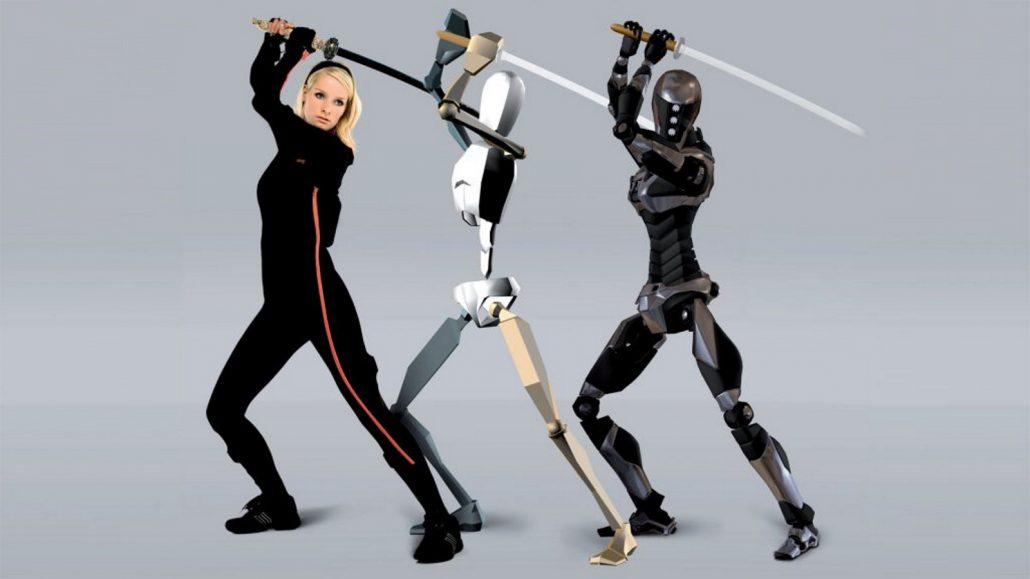

How could we capture or analyze motion?
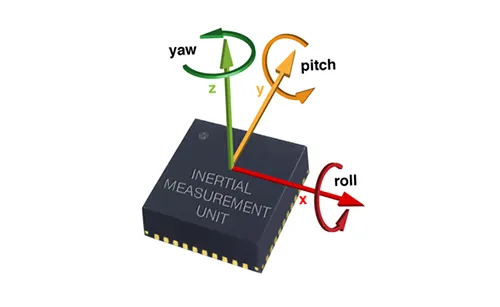

What we want

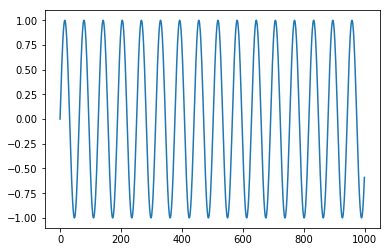

In [6]:
plt.plot(np.sin(np.arange(0,100,0.1)))

What we have

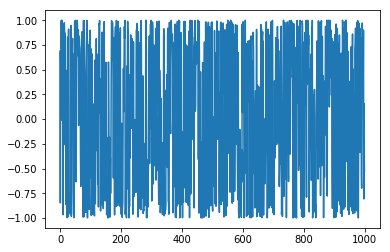

In [7]:
data = (np.sin(np.arange(0,100,0.1)+10*np.random.rand(1,len(np.arange(0,100,0.1)))))
plt.plot(data[0])

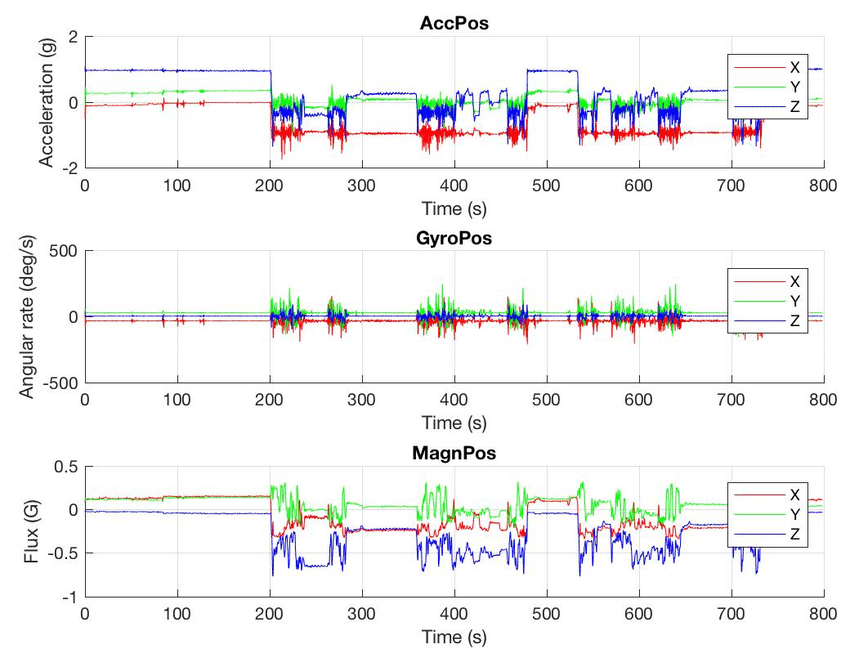

To understan is it possible to compare two motions we need to check the similarity of the two signal

correlation

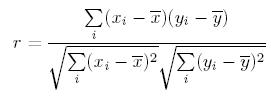

In [8]:
def calc_std(x):
    return np.sqrt(np.sum(np.power(x-np.mean(x),2))/(len(x)-1))

In [9]:
def calc_correl(x,y):
    if(not(len(x) == len(y))):
        return 0
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    #print('x mean = '+str(x_mean)+' y mean = ' + str(y_mean))
    s_x = calc_std(x)
    s_y = calc_std(y)
    #print('x std = '+str(s_x)+' y std = ' + str(s_y))
    z_x = (x-x_mean)/s_x
    z_y = (y-y_mean)/s_y
    #print(('z_x = '+str(z_x)+' z_y = ' + str(z_y)))
    x_y_cov = np.sum(z_x*z_y)
    r = 1/(len(x)-1) * x_y_cov
    return r
    

In [10]:
def norm_by_ref(unnorm_data,unnorm_ref_data):
    unnormalized_data = unnorm_data.copy()
    unnormalized_data = (unnormalized_data - np.nanmin(unnormalized_data))/(np.nanmax(unnorm_ref_data)-np.nanmin(unnorm_ref_data))
    return unnormalized_data

In [11]:
def norm_data(unnorm_data):
    unnormalized_data = unnorm_data.copy()
    unnormalized_data = (unnormalized_data - np.nanmin(unnormalized_data))/(np.nanmax(unnormalized_data)-np.nanmin(unnormalized_data))
    return unnormalized_data

1.0
-0.41036467732879783
[[1. 1.]
 [1. 1.]]
-0.045111264231963655
[[1. 1.]
 [1. 1.]]


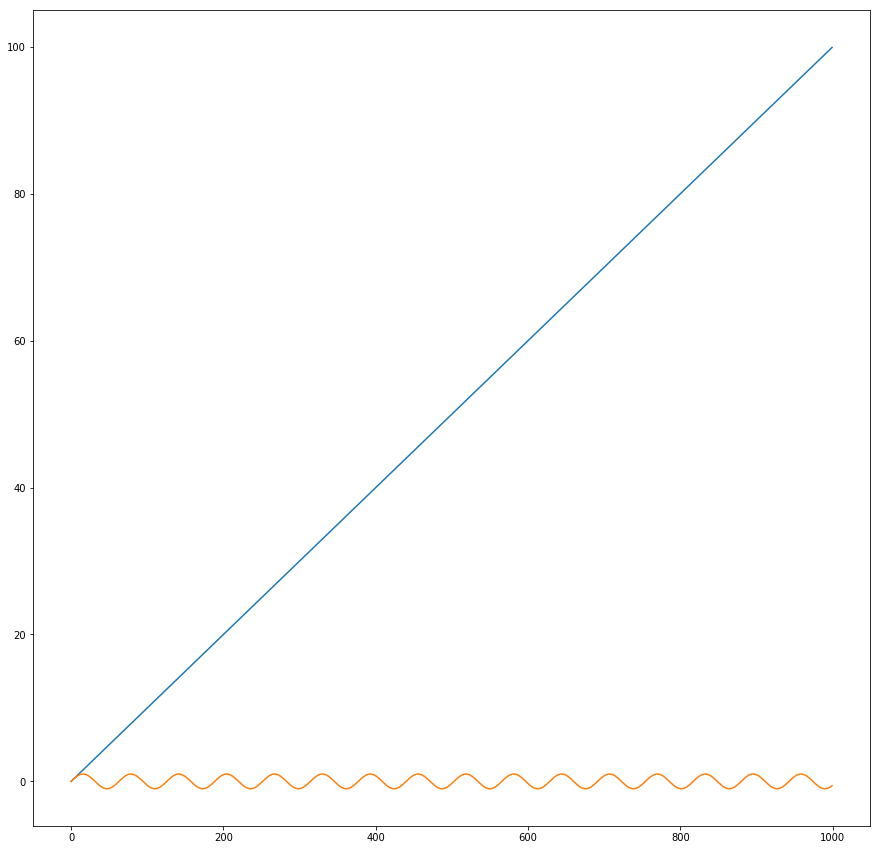

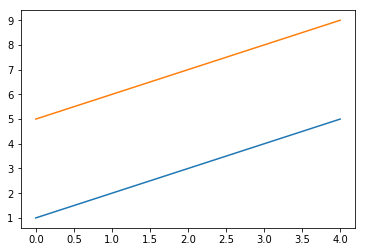

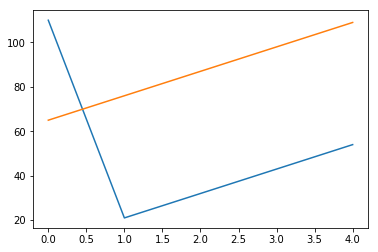

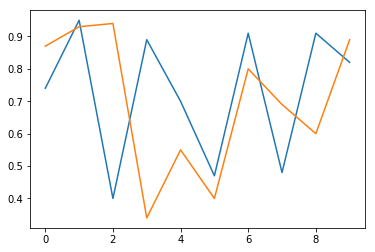

In [12]:
sig1 = np.arange(0,100,0.1)
sig2 = np.sin(sig1)
sig3 = [1,2,3,4,5]
sig4 = [5,6,7,8,9]
sig5 = [110,21,32,43,54]
sig6 = [65,76,87,98,109]
print(calc_correl(sig3,sig4))
print(calc_correl(sig5,sig6))
a =np.array([0.74,0.95,0.40,0.89,0.70,0.47,0.91,0.48,0.91,0.82])
b = np.array([0.87,0.93,0.94,0.34,0.55,0.40,0.80,0.69,0.6,0.89])
calc_correl(a,b)
plt.figure(figsize=(15,15))
plt.plot(sig1)
plt.plot(sig2)
print(np.corrcoef(sig3,sig4))
plt.figure()
plt.plot(sig3)
plt.plot(sig4)
plt.figure()
plt.plot(sig5)
plt.plot(sig6)
plt.figure()
plt.plot(a)
plt.plot(b)
print(calc_correl(sig1,sig2))

print(np.corrcoef(sig3,sig4))
sig3 = norm_by_ref(sig3,sig4)
sig4 = norm_data(sig4)


In [13]:
calc_correl(sig3,sig4)

1.0

Leg acceleration data

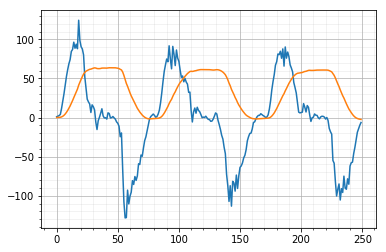

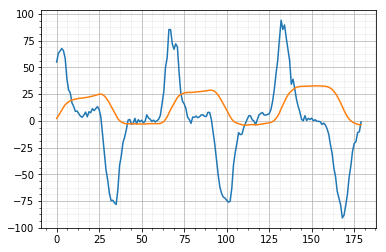

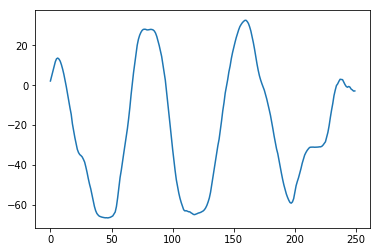

In [14]:
#plt.figure(figsize=(15,15))
#plt.plot(user_raw_data['leg_gyro_z'])
#plt.figure(figsize=(15,15))
#plt.plot(ref_data.x,ref_data.y)
#plt.figure(figsize=(15,15))
#plt.plot(beate['leg_gyro_z'])
#plt.figure(figsize=(15,15))
major_ticks = np.arange(0, 101, 20)
minor_ticks = np.arange(0, 101, 5)
plt.plot(beate_ref['leg_gyro_x'][120:370].values)
plt.plot(np.cumsum(beate_ref['leg_gyro_x'][120:370].values)/25)
plt.minorticks_on()
plt.grid(which='minor',alpha = 0.2)
plt.grid(which='major',alpha = 0.9)
plt.figure()
plt.minorticks_on()
plt.plot(-beate['leg_gyro_x'][130:310].values)
plt.plot(np.cumsum(-beate['leg_gyro_x'][130:310].values)/25)
plt.grid(which='minor',alpha = 0.2)
plt.grid(which='major',alpha = 0.9)
#plt.plot(beate_ref['leg_gyro_y'])
#plt.plot(beate['leg_gyro_y'])
#plt.figure()
#plt.plot(beate_ref['leg_gyro_z'])
plt.figure()
plt.plot(np.cumsum(-beate['leg_gyro_x'][130:380].values)/25 - np.cumsum(beate_ref['leg_gyro_x'][120:370].values)/25)

In [15]:
def auto_correlation_circ(data):
    auto_correlation = np.empty(0)
    for i in range(0,data.size):
        auto_correlation = np.append(auto_correlation,np.correlate(data,np.roll(data,-i),'valid'))
    return auto_correlation

def strech_signal(signal,final_length):
    return np.interp(np.linspace(0,signal.size,final_length),np.arange(0,signal.size),signal)

def strech_array(array,final_length):
    new_array = np.empty(final_length)
    new_array = new_array.reshape(1,new_array.size)
    for signal in np.transpose(array):
        signal = strech_signal(signal,final_length)
        new_array = np.vstack([new_array,signal])
    return new_array

def movement_separetion(raw_movement_data):
    auto_corr = auto_correlation(raw_movement_data)
    peaks,_ = scipy.signal.find_peaks(auto_corr)
    movements = np.empty(len(raw_movement_data[peaks[1]:peaks[2]]))
    movements = movements.reshape(1,movements.size)
    for i in np.arange(1,peaks.size-1):
        print(i)
        if(peaks[i+1]-peaks[i] == movements.shape[1]):
            print('equal')
            movements = np.vstack([movements,raw_movement_data[peaks[i]:peaks[i+1]]])
        elif(peaks[i+1]-peaks[i] > movements.shape[1]):
            print('bigger')
            movements = strech_array(movements,peaks[i+1]-peaks[i])
            movements = np.vstack([movements,raw_movement_data[peaks[i]:peaks[i+1]]])
        elif(peaks[i+1]-peaks[i] < movements.shape[1]):
            print('smaller')
            streched_data = strech_signal(raw_movement_data[peaks[i]:peaks[i+1]],peaks[i+1]-peaks[i])
            movements = np.vstack([movements,streched_data])
        print(movements.shape)
    return movements

def moving_average(data,window):
    aver = np.zeros(window)
    for i in range(0,data.size-window):
        aver = np.append(aver,np.mean(data[i:i+window]))
    return aver 

def sign_change(data):
    return (np.sign(data) - np.roll(np.sign(data),1))

[ 68 136 203 269 331 397 464 532] [0.87 0.93 0.94 0.34 0.55 0.4  0.8  0.69 0.6  0.89]


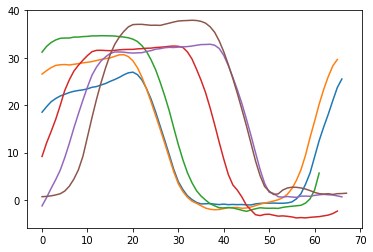

In [16]:
trainer_angle_data = np.cumsum(-beate['leg_gyro_x'].values)/25
auto_corr = auto_correlation_circ(trainer_angle_data)
a,_ = scipy.signal.find_peaks(auto_corr)
print(a,b)
plt.figure()
for i in np.arange(1,a.size-1):
    #plt.plot(a,y_[a],'rx')
    plt.plot(trainer_angle_data[a[i]:a[i+1]])
#plt.xlim([0,len(beate)])

In [17]:
def interpol(y,new_size):
    new_x = np.linspace(0,len(y)-1,new_size)
    old_x = np.arange(0,len(y))
    new_array = np.empty([0])
    i=0
    for x in new_x:
        if old_x[i+1]<x:
            i+=1
        if i>=(len(y)-1):
            break
        new_array = np.append(new_array,y[i]+(y[i+1]-y[i])*((x-old_x[i])/(old_x[i+1]-old_x[i])))
    return new_array

In [18]:
def eucl_dist(res_point,ref_curve):
    distances = np.empty(0)
    for point in ref_curve:
        dist = np.sqrt(np.power(res_point.x-point.x,2)+np.power(res_point.y-point.y,2))
        distances = np.append(distances,dist)
    return distances

In [19]:
def dtw_matrix(res_curve,ref_curve):
    DTW = np.ones([len(ref_curve),len(res_curve)])*np.inf
    DTW[0,0] = 0
    for i in range (1,len(ref_curve)):
        for j in range (1,len(res_curve)):
            cost = (ref_curve.y[i] - res_curve.y[j])*(np.log10(ref_curve.x[i]) - np.log10(res_curve.x[j]))
            DTW[i, j] = cost + np.sum(DTW[i-1,j-1],DTW[i,j-1],DTW[i+1,j-1],
                                    )
    
    return DTW
    
    
    
    
#    dm = np.empty(len(ref_curve))
#    for point in res_curve:
#        dm = np.vstack([dm,eucl_dist(point,ref_curve)])
#    return np.delete(dm,0,0)

In [20]:
def dtw_matrix(user,ref):
    dtw = np.empty([len(ref),len(user)])
    for i in range(0,len(ref)-1):
        for j in range(0,len(user)-1):
            #print(ref[i])
            #print(user[j])
            #dtw[i,j] = np.sqrt((ref.y[i] - user.y[j])**2 + (ref.x[i] - user.x[j])**2)
            dtw[i,j] = ref.y[i]-user.y[j]
    return dtw

100 66


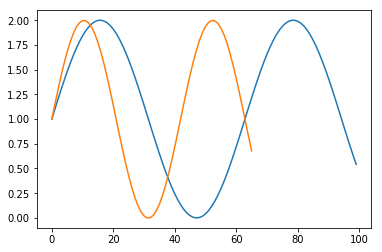

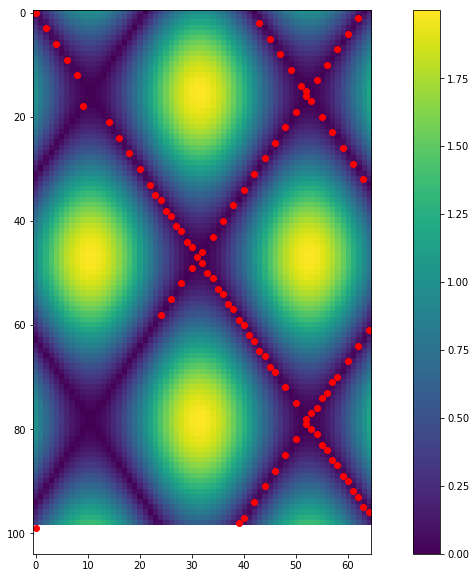

In [21]:

x1 = np.arange(0,10,0.1)
x2 = np.arange(0,6.6,0.1)
ref = curve(x1,np.sin(x1))
user = curve(x2,np.sin(1.5 * x2))
ref.y -= np.min(ref.y)
user.y -= np.min(user.y)
plt.plot(ref.y)
plt.plot(user.y)


dtw = np.abs(dtw_matrix(user,ref))
#np.where(dtw==0)

plt.figure(figsize=(15,10))
plt.imshow(dtw[:-1,:-1])
plt.colorbar()
i = 0
for line in dtw:
    plt.plot(np.argmin(line[:-1]),i,'ro')
    i+=1
print(len(ref),len(user))

In [22]:
new_arr = np.empty([0])
dtw_points = np.where(dtw==0)
for i in range(0,len(dtw_points[1])-1):
    interp_segment = user.y[int(dtw_points[1][i]):int(dtw_points[1][i+1]+1)]
    interp_result = interpol(interp_segment,dtw_points[0][i+1] - dtw_points[0][i]+1)
    new_arr = np.append(new_arr,interp_result[0:-1])

IndexError: index 1 is out of bounds for axis 0 with size 1

In [23]:
plt.plot(new_arr+4)
plt.plot(ref.y+2)
plt.plot(new_arr-ref.y[0:dtw_points[0][-1]])
plt.grid()

ValueError: operands could not be broadcast together with shapes (31,) (99,) 

In [24]:
ref_dat_len = 100



user_activity = (user_raw_data[user_raw_data['class'] == 'Running']['leg_gyro_z'].values)#*(180/np.pi)
#alex_max_val = np.max(alex_running)
#alex_running = savgol_filter(alex[alex['class'] == 'Running']['leg_gyro_z'].values,17,3)
#alex_running = norm_data(alex_running)*alex_max_val
user_activity_angles = np.array([0])
for dot in user_activity:
    user_activity_angles = np.append(user_activity_angles,(user_activity_angles[-1]+dot/25))
norm_user_activity_angles = curve(np.arange(0,len(user_activity_angles)),(user_activity_angles - np.min(user_activity_angles))/(np.max(user_activity_angles) - np.min(user_activity_angles)))
norm_ref_data = curve(ref_data.x,(ref_data.y - np.min(ref_data.y))/(np.max(ref_data.y) - np.min(ref_data.y)))
norm_ref_data.y = np.interp(np.arange(0,len(norm_ref_data),len(norm_ref_data)/ref_dat_len),np.arange(0,len(norm_ref_data)),norm_ref_data.y)


1264
1264
1264


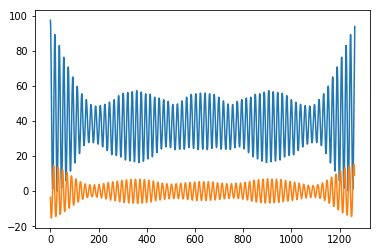

In [25]:
corr = auto_correlation_circ(norm_data(user_activity_angles - moving_average(user_activity_angles,50)))
diff_corr = np.diff(corr)
mask = sign_change(diff_corr)<=0
mask = np.append(False,mask)
plt.plot(corr-min(corr))
plt.plot(np.diff(corr))
print(mask.size)
print(corr.size)
print(user_activity_angles.size)


(500, 1000)

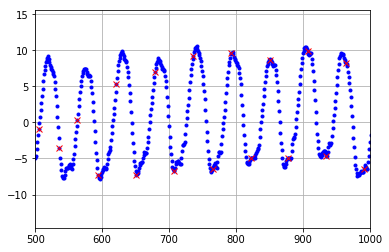

In [26]:
pre_prop_data = user_activity_angles - moving_average(user_activity_angles,50)
pre_prop_data -= np.mean(pre_prop_data)
pre_prop_data = np.interp(np.linspace(0,pre_prop_data.size,pre_prop_data.size*3),np.arange(0,pre_prop_data.size),pre_prop_data)
corr = auto_correlation_circ(norm_data(pre_prop_data))
diff_corr = np.diff(corr)
mask = sign_change(diff_corr)!=0
mask = np.append(False,mask)
plt.plot(pre_prop_data,'.b')

#plt.plot(user_activity_angles)
plt.plot(np.arange(0,pre_prop_data.size)[mask],pre_prop_data[mask],'rx')
plt.grid()
plt.xlim([500,1000])

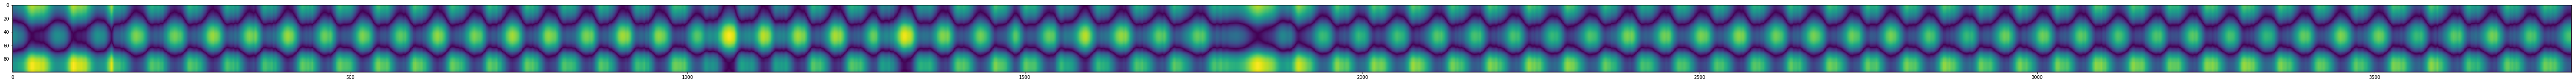

In [27]:
plt.figure(figsize=(100,100))
pre_prop_curve = curve(np.arange(0,pre_prop_data.size),norm_data(pre_prop_data))
plt.imshow(np.abs(dtw_matrix(pre_prop_curve,norm_ref_data)))
#plt.ylim([0,500])

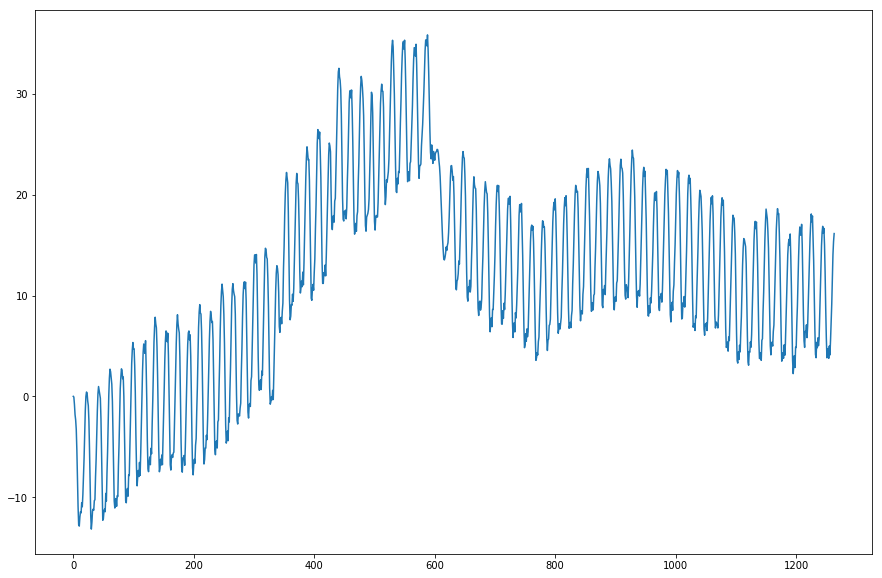

In [28]:

conv = norm_data(scipy.signal.fftconvolve(user_activity_angles,user_activity_angles,'full')[:len(user_activity_angles)])
pk,_ = scipy.signal.find_peaks(-conv)

plt.figure(figsize=(15,10))
plt.plot(user_activity_angles)
#for i in pk:
#    plt.plot([i,i],[np.min(user_activity_angles),np.max(user_activity_angles)],'y')
#    pass
#plt.plot(user_activity_angles)
#plt.plot((ref_data.y-np.mean(ref_data.y)))#*(np.pi/180))


#plt.xlim([2000,3000])
#plt.ylim([0,0.01])


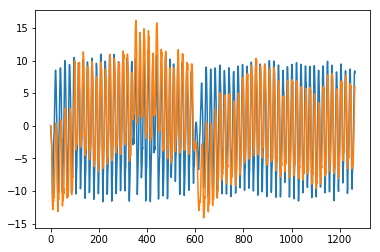

In [29]:
 
win = 10
plt.plot(user_activity_angles - moving_average(user_activity_angles,win))
#plt.xlim([0,900])
win = 100
plt.plot(user_activity_angles - moving_average(user_activity_angles,win))
#plt.xlim([0,900])

4500


"sprtr = 0\nsz = len(test_user_data)\ni = 0\nwhile sprtr < sz-1:\n    test_user_data = curve(np.arange(0,test_user_data.y[int(sprtr):].size),test_user_data.y[int(sprtr):])\n    dtw = dtw_matrix(test_user_data,test_ref_data)\n    test_pth = find_path(np.abs(dtw))\n    plt.plot(test_pth[:,1]+i,test_pth[:,0],'r.')\n    sprtr = test_pth[-1,-2]\n    i+=sprtr\n    \n    print(sprtr,test_pth[-1,-2])\n    if(sprtr == 0):\n        break\n    \n#plt.xlim([300,750])"

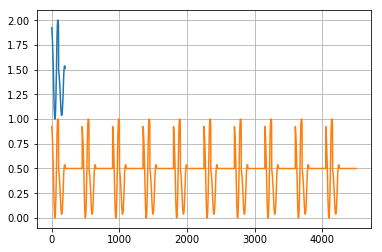

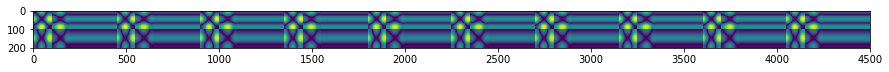

In [30]:
test_ref_data = norm_data(np.append(ref_data.y,ref_data.y/2))
test_user_data = np.empty(0)
for i in range(0,10):
    test_user_data = np.append(test_user_data,test_ref_data)
    test_user_data = np.append(test_user_data,np.ones(250)*0.5)
test_ref_data = curve(np.arange(0,test_ref_data.size),test_ref_data)
test_user_data = curve(np.arange(0,test_user_data.size),test_user_data)
#test_user_data.y += np.random.rand(test_user_data.y.size)
plt.plot(test_ref_data.y+1)
plt.plot(test_user_data.y)
plt.grid()
plt.figure(figsize=(15,10))
dtw = dtw_matrix(test_user_data,test_ref_data)
plt.imshow(np.abs(dtw))
print(len(test_user_data))
"""sprtr = 0
sz = len(test_user_data)
i = 0
while sprtr < sz-1:
    test_user_data = curve(np.arange(0,test_user_data.y[int(sprtr):].size),test_user_data.y[int(sprtr):])
    dtw = dtw_matrix(test_user_data,test_ref_data)
    test_pth = find_path(np.abs(dtw))
    plt.plot(test_pth[:,1]+i,test_pth[:,0],'r.')
    sprtr = test_pth[-1,-2]
    i+=sprtr
    
    print(sprtr,test_pth[-1,-2])
    if(sprtr == 0):
        break
    
#plt.xlim([300,750])"""

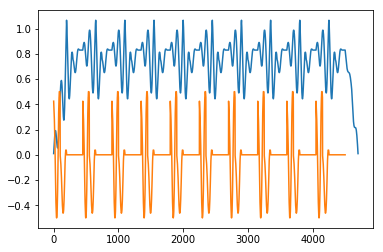

In [31]:
fltr = np.flip(test_ref_data.y)
cnvlv = np.convolve(fltr,test_user_data.y,'full')
plt.plot(cnvlv/50)
plt.plot(test_user_data.y-0.5)

In [32]:

print(sprtr)
plt.imshow(np.abs(dtw[:,sprtr:]))

NameError: name 'sprtr' is not defined

In [33]:
 def find_signal_start(dtw_mtrx,strt):
    i = 0
    min_diff = np.inf
    indx = 0
    for i in range(strt,len(dtw_mtrx[0,:])-1):
        if(dtw_mtrx[0,i] - dtw_mtrx[0,i+1] < 0):
            indx = i
            return indx
        i+=1
    return -1
def find_signal_end(dtw_mtrx,strt):
    i = 0
    min_diff = np.inf
    indx = 0
    for i in range(strt,len(dtw_mtrx[0,:])-1):
        if(dtw_mtrx[0,i] - dtw_mtrx[0,i+1] > 0):
            indx = i
            return indx
        i+=1
    return -1
def find_start_and_end(dtw_mat,start):
    start = find_signal_start(dtw_mat,start)
    end = find_signal_start(dtw_mat,find_signal_end(dtw_mat,start))+1
    return start,end

def find_end_of_step(sep_stp):
    for i in range(0,len(sep_stp)-1):
        if((sep_stp[i] == 0) and (sep_stp[i+1] == 0)):
            return i
    return i

In [34]:
def find_path(mat):
    start = [0,0]
    end = [-1,-1]
    for i in range(0,mat[:,0].size):
        mat[i,:]+=mat[:,0].size-i


In [35]:
def find_path(mat,stop_at_rows_end=False,stop_at_collumns_end=False):
    temp = np.ones([mat.shape[0]+1,mat.shape[1]+1])*np.inf
    temp[:-1,:-1] = mat
    mat = temp
    path = np.array([[0,0,mat[0,0]]])
    i = 0 #rows
    j = 0 #collumns
    cont_cond = True
    while (cont_cond):
        n0 = mat[i+1,j+1]# + surr_cost(mat,i+1,j+1)
        n1 = mat[i+1,j]# + surr_cost(mat,i+1,j)
        n2 = mat[i,j+1]# + surr_cost(mat,i,j+1)
        neighbors = [n0,n1,n2]
        arg = np.argmin(neighbors)
        if(arg == 0) or (neighbors[0] == neighbors[1] == neighbors[2]):
            j+=1
            i+=1
        elif(arg == 1):
            i+=1
        elif(arg == 2):
            j+=1

            
        
        cont_cond = (i < mat[:,0].size-3) and (j < mat[0,:].size-3)
        """ 
        if(i>=mat[:,0].size-1):
            i-=1
        if(j>=mat[0,:].size-1):
            j-=1
        """
        if mat[i,j] < np.inf:
            new_point = [i,j,mat[i,j]]
            path = np.vstack([path,new_point])
    return path

In [36]:
def separate_moves(user_data,norm_user_data,reference_data):
    dtw_mat = dtw_matrix(norm_user_data,reference_data)
    start = 0
    end = 1
    sp_stps = np.ones([1,50]) * np.nan
    nan_arr = np.ones([1,50]) * np.nan
    while (start >= 0) and (end > 0) and (start <= end):
        start, end = find_start_and_end(dtw_mat,end)
        #print(sp_stps.shape,nan_arr.shape)
        if (start >= 0) and (end > 0) and (start <= end) :
            for i in range(start,end+1):
                sp_stps[-1,i-start] = user_data[i]
        else:
            break
        sp_stps = np.vstack([sp_stps,nan_arr])
    return sp_stps[:-1]

In [37]:
def line_local_minimum(line):
    line_prim =np.append(0,line[:-1]-line[1:])
    return line_prim


In [38]:
def separate_moves(norm_user_data,norm_reference_data):
    dtw = dtw_matrix(norm_user_data,norm_reference_data)
    separators = np.array([0])
    new_y = 0
    while new_y < len(norm_user_data)-1:
        pth_ = find_path(np.abs(dtw[:,new_y:]))
        separators = np.append(separators,new_y)
        new_y += int(pth_[-1,-2])
    return separators
        

(0, 120)

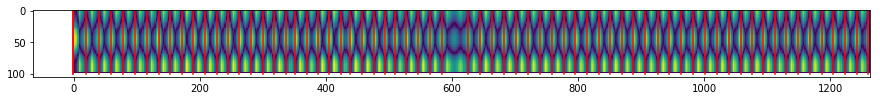

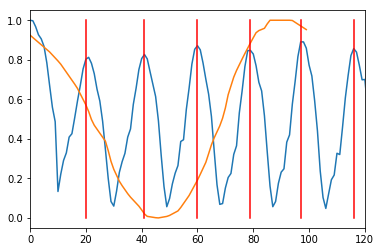

In [39]:
#plt.figure(figsize=(100,100))
#a = curve(norm_user_activity_angles.x[20:150],norm_data(norm_user_activity_angles.y[20:150]))
a = curve(norm_user_activity_angles.x,norm_data(norm_user_activity_angles.y-moving_average(norm_user_activity_angles.y,10)))
a.y -= np.min(a.y)
#a.y = np.cumsum(a.copy().y)
b = norm_ref_data.copy()
#b.y = np.cumsum(b.y)
plt.figure(0,figsize=(15,10))
#start_t = time.time()
seps = separate_moves(a,b)-1
dtw = dtw_matrix(a,b)
#stop_t = time.time()
#print(stop_t-start_t)
plt.imshow(np.abs(dtw))
plt.figure(1)
plt.plot(a.y)
plt.plot(b.y)
for separator in seps:
    plt.figure(0)
    plt.plot([separator,separator],[0,len(b)],'r')
    plt.figure(1)
    plt.plot([separator,separator],[0,1],'r')
plt.xlim([0,120])

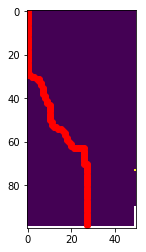

In [40]:
#plt.figure(figsize=(100,100))
plt.imshow(np.abs(dtw_matrix(curve(norm_user_activity_angles.x[:50],norm_user_activity_angles.y[:50]),norm_ref_data)))
pth_mat = find_path(np.abs(dtw_matrix(curve(norm_user_activity_angles.x[:50],norm_user_activity_angles.y[:50]),norm_ref_data)))
plt.plot(pth_mat[:,1],pth_mat[:,0],'ro')
#plt.xlim([0,100])
sep_steps = separate_moves(norm_user_activity_angles,norm_ref_data)
#sep_steps = separate_moves(user.y,curve(user.x,norm_data(user.y)),norm_ref_data)



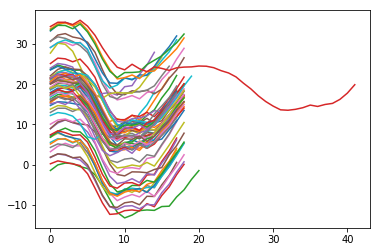

In [41]:
for i in np.arange(0,seps.size-1):
    plt.plot(user_activity_angles[seps[i]:seps[i+1]])

In [42]:
def stretching(user_data,reference_data,path):
    uni, counts = np.unique(path[:,1], return_counts=True)
    uni = np.append(uni,uni[-1]+1)
    counts[0]+=2
    counts = np.append(counts,0)
    new_x = np.empty([0])
    for i in np.arange(uni[0],uni[-1],dtype=np.int):
        #if counts[i] > 1:
        x_section = np.linspace(uni[i],uni[i+1],counts[i]+1)[:-1]
        new_x = np.append(new_x,x_section)
        #elif counts[i] == 1 and i > 1:
        #    x_section = new_x[-1] + (new_x[-1] - new_x[-2]) * 1.5
        #    new_x[-1]  += (new_x[-1] - new_x[-2]) * 0.5
        #else:
        #    pass        
    #len_x = len(new_x)
    #if (len(reference_data)-len(new_x))>0:
    #    new_x = np.append(new_x,np.linspace(new_x[-1],len(reference_data),len(reference_data)-len(new_x)))
    #new_x = new_x[:len(reference_data)]
    print(new_x[0],new_x[-1],user_data.x[0],user_data.x[-1])
    new_y = np.interp(new_x,user_data.x,user_data.y)#,period = len(reference_data))
    new_user = curve(new_x,new_y)

    new_ref = curve(new_x,new_y)
    return new_user,new_ref

In [43]:
def stretching(user_data,reference_data,path):
    streched_reference_data = np.interp(np.array(path)[:,0],np.arange(0,len(reference_data)),reference_data.y)
    streched_reference_data -= np.min(streched_reference_data)
    streched_user_data = np.interp(np.array(path)[:,1],np.arange(0,len(user_data)),user_data.y)
    streched_user_data -= np.min(streched_user_data)
    return curve(np.array(path)[:,1],streched_user_data),curve(np.array(path)[:,0],streched_reference_data)

In [44]:
def time_to_excercise_domain(user_data,reference_data):
    user_data.y -= np.nanmin(user_data.y)
    pth = find_path(np.abs(dtw_matrix(copy.copy(user_data),copy.copy(reference_data))))
    streched_y = stretching(user_data,reference_data,pth)
    return streched_y

In [45]:
def time_to_excercise_domain(user_data,reference_data):
    dist,path = fastdtw(reference_data.y-np.mean(reference_data.y),user_data.y)
    user,ref = stretching(copy.copy(user_data),copy.copy(reference_data),path)
    return user,ref

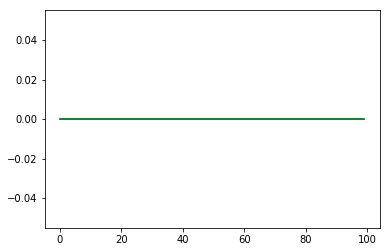

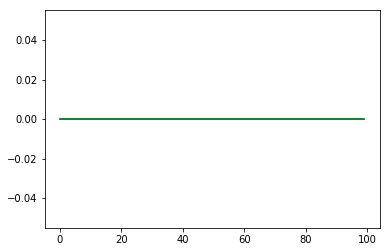

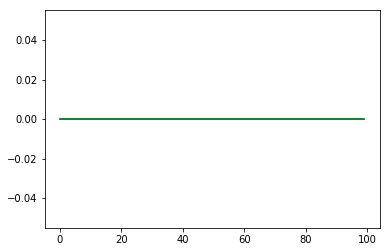

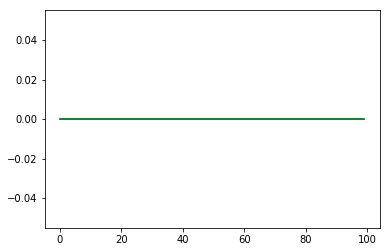

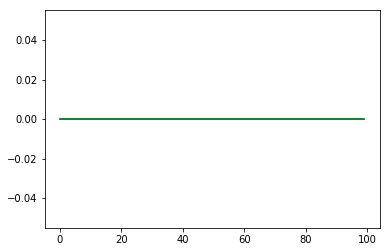

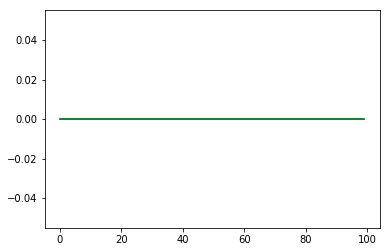

In [46]:
i = 0

for stp in sep_steps:
    stp = stp[np.logical_not(np.isnan(stp))]
    stp_x = np.linspace(0,len(stp),len(ref_data))
    stp_y = np.interp(stp_x,np.arange(0,len(stp)),stp)
    stp = curve(stp_x,stp_y)
    stp.y = stp.y-min(stp.y)
    
    processed_data,new_ref_data = time_to_excercise_domain(copy.copy(stp),copy.copy(ref_data))
    plt.figure()
    plt.plot(stp.y)
    #plt.plot(new_ref_data.y,'r')
    plt.plot(processed_data.y,'g')
    i+=1
    if(i>5):
        pass
        break 

In [47]:
import numpy as np

def KL(P,Q):
    """ Epsilon is used here to avoid conditional code for checking that neither P nor Q is equal to 0. """
    epsilon = 0.00001
    # You may want to instead make copies to avoid changing the np arrays.
    P = P+epsilon
    Q = Q+epsilon
    divergence = np.sum(P*np.log(P/Q))
    return divergence

# Should be normalized though
values1 = norm_by_ref(stp.y,ref_data.y)
values2 = norm_data(ref_data.y)
print(len(values1),len(values2))
# Note slight difference in the final result compared to Dawny33
print (KL(values1, values2)) # 0.775278939433

100 100
-0.01016358127269189


In [48]:
olga_sallary = 1800
yuri_sallary = 3000
child_money_yuri_working = yuri_sallary*0.6*0.3
child_money_olga_working = olga_sallery*0.6*0.3
child_money_yuri_nw = yuri_sallary*0.6
child_money_olga_nw = olga_sallery*0.6
monthly_income_olga_working = olga_sallery+yuri_sallary+child_money_olga_working
monthly_income_yuri_working = olga_sallery+yuri_sallary+child_money_yuri_working
monthly_income_olga_nw = yuri_sallary+child_money_olga_nw
monthly_income_yuri_nw = olga_sallary+child_money_yuri_nw

print(monthly_income_olga_nw,monthly_income_olga_working,monthly_income_yuri_nw,monthly_income_yuri_working)

NameError: name 'olga_sallery' is not defined

In [49]:
ecg_raw = pd.DataFrame(pd.read_csv('D:\Dropbox\Ju\EDI\Convergence\CapturedData\ecg_test\ecg.csv'))
ecg_ref = pd.DataFrame(pd.read_csv('D:\Dropbox\Ju\EDI\Convergence\CapturedData\ecg_test\IdealECG.csv',header=None))
ecg = norm_data(ecg_raw['mV'])#[900:1600])
ecg -= np.mean(ecg)
ecg = curve(np.arange(0,ecg.size),ecg)

ecg_ref = curve(ecg_ref[0],-ecg_ref[1])
ecg_ref.y-=np.min(ecg_ref.y)
ecg_ref_x_interp = np.linspace(0,ecg_ref.x[-1],len(ecg_ref)*10)
ecg_ref_y_interp = norm_data(np.interp(ecg_ref_x_interp,ecg_ref.x,ecg_ref.y))
ecg_ref = curve(ecg_ref_x_interp,ecg_ref_y_interp)
ecg_ref.y-=np.mean(ecg_ref.y)

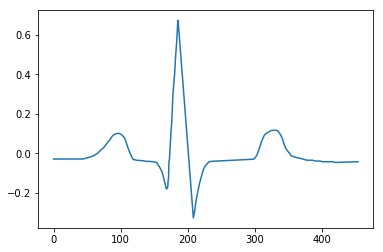

In [50]:

plt.plot(ecg_ref.x,ecg_ref.y)

76.0
75.0
89.0
86.0
74.0
96.0
82.0
73.0
90.0
364.0


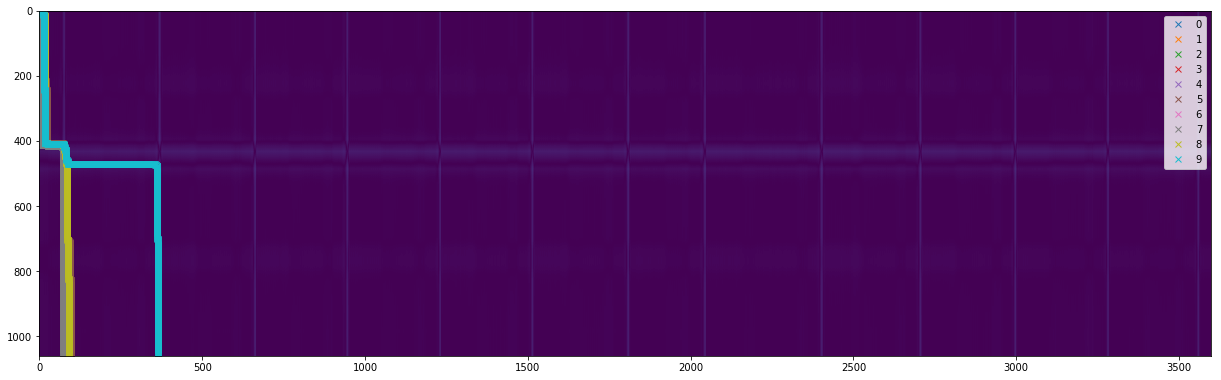

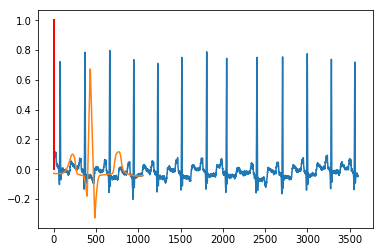

In [51]:
plt.figure(0,figsize=(7*3,5*3))
dtw = np.abs(dtw_matrix(ecg,ecg_ref))
seps = np.array([0])
new_y = 0
hor_mod = 5
ver_mod = 2

#for i in range(0,dtw[:,0].size):
    #dtw[i,:] += (dtw[:,0].size-i)/(dtw[:,0].size/ver_mod)
#    dtw[i,:] = norm_data(dtw[i,:])

#for i in range(0,dtw[0,:].size):
    #dtw[:,i] += hor_mod*(dtw[0,:].size-i)/(dtw[0,:].size/hor_mod)
#    dtw[:,i] = norm_data(dtw[:,i])


#"""
i = 10
while i>0:#new_y < len(ecg)-1:
    pth_ = find_path(dtw)
    seps = np.append(seps,new_y)
    plt.plot(pth_[:,1],pth_[:,0],'x')
    ###new_y += int(pth_[-1,-2])
    print(pth_[-1,-2])
    i-=1
    for iks,igrek in zip(pth_[:,1],pth_[:,0]):
        try:
            dtw[int(igrek),int(iks)]+=1
        except:
            pass
    if(pth_[-1,-2] == 0):
        break
#"""

#stop_t = time.time()
#print(stop_t-start_t)
plt.imshow(dtw)#np.abs(dtw[200:300,:300]))
plt.legend(np.arange(0,10))
plt.figure(1)
plt.plot(ecg.y)
plt.plot(ecg_ref.y)
#plt.plot(moving_average(ecg_ref.y,25))

for separator in seps:
    #plt.figure(0)
    #plt.plot([separator,separator],[0,len(ecg_ref)],'r')
    #plt.figure(1)
    plt.plot([separator,separator],[0,1],'r')
#plt.xlim([0,120])

In [ ]:
def __expand_window(path, len_x, len_y, radius):
    path_ = set(path)
    for i, j in path:
        for a, b in ((i + a, j + b)
                     for a in range(-radius, radius+1)
                     for b in range(-radius, radius+1)):
            path_.add((a, b))

    window_ = set()
    for i, j in path_:
        for a, b in ((i * 2, j * 2), (i * 2, j * 2 + 1),
                     (i * 2 + 1, j * 2), (i * 2 + 1, j * 2 + 1)):
            window_.add((a, b))

    window = []
    start_j = 0
    for i in range(0, len_x):
        new_start_j = None
        for j in range(start_j, len_y):
            if (i, j) in window_:
                window.append((i, j))
                if new_start_j is None:
                    new_start_j = j
            elif new_start_j is not None:
                break
        start_j = new_start_j

    return window

In [64]:
def __dtw(x, y, window, dist=euclidean):
    len_x, len_y = len(x), len(y)
    if window is None:
        window = [(i, j) for i in range(len_x) for j in range(len_y)]
    window = ((i + 1, j + 1) for i, j in window)
    D = defaultdict(lambda: (float('inf'),))
    D[0, 0] = (0, 0, 0)
    for i, j in window:
        dt = np.abs(np.abs(x[i-1]) - np.abs(y[j-1]))
        D[i, j] = min((D[i-1, j][0]+dt, i-1, j), (D[i, j-1][0]+dt, i, j-1),
                      (D[i-1, j-1][0]+dt, i-1, j-1), key=lambda a: a[0])
    return D
    path = []
    i, j = len_x, len_y
    while not (i == j == 0):
        path.append((i-1, j-1))
        i, j = D[i, j][1], D[i, j][2]
    path.reverse()
    return (D[len_x, len_y][0], path)

In [65]:
dtw = __dtw(ecg.y,ecg_ref.y,None)
plt.imshow(dtw)

TypeError: Image data cannot be converted to float

In [68]:
dtw

38005709159, 1, 259),
             (0, 261): (inf,),
             (1, 261): (17.851121979651598, 1, 260),
             (0, 262): (inf,),
             (1, 262): (17.942531066546376, 1, 261),
             (0, 263): (inf,),
             (1, 263): (18.037607317775922, 1, 262),
             (0, 264): (inf,),
             (1, 264): (18.136350733340237, 1, 263),
             (0, 265): (inf,),
             (1, 265): (18.23856178016225, 1, 264),
             (0, 266): (inf,),
             (1, 266): (18.34415790175482, 1, 265),
             (0, 267): (inf,),
             (1, 267): (18.45311886481812, 1, 266),
             (0, 268): (inf,),
             (1, 268): (18.558694753110863, 1, 267),
             (0, 269): (inf,),
             (1, 269): (18.660885566633052, 1, 268),
             (0, 270): (inf,),
             (1, 270): (18.759691305384685, 1, 269),
             (0, 271): (inf,),
             (1, 271): (18.855111969365762, 1, 270),
             (0, 272): (inf,),
             (1, 272): (18

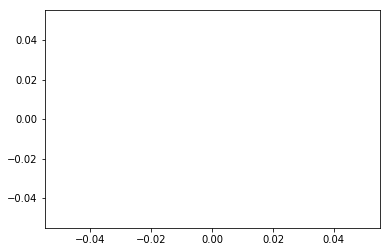

In [55]:
for i in np.arange(0,seps.size-1):
    plt.plot(ecg.y[seps[i]:seps[i+1]]+i)

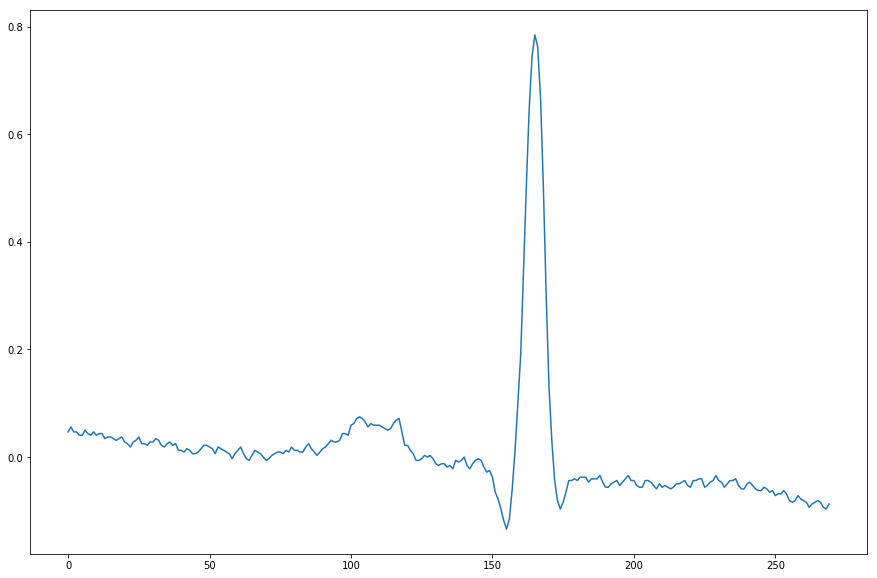

In [56]:
#plt.plot((line_local_minimum(dtw[0,250:])))
#plt.xlim([0,600])
#plt.figure()
#plt.plot(ecg.y[250:850])
plt.figure(figsize=(15,10))
#plt.plot(ecg_ref.y)
#plt.plot(moving_average(line_local_minimum(dtw[0,:]),5))
plt.plot(ecg.y[205:475])